Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Loaded initial model
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/7


/usr/local/lib/python3.5/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


300/300 [==============================] - 108s 359ms/step - loss: 3.4993 - val_loss: 0.6931
Epoch 2/7
300/300 [==============================] - 82s 273ms/step - loss: 1.9550 - val_loss: 0.6931
Epoch 3/7
300/300 [==============================] - 83s 276ms/step - loss: 1.6759 - val_loss: 0.6931
Epoch 4/7
300/300 [==============================] - 84s 280ms/step - loss: 0.9096 - val_loss: 0.6931
Epoch 5/7
300/300 [==============================] - 85s 284ms/step - loss: 0.6050 - val_loss: 0.6931
Epoch 6/7
300/300 [==============================] - 86s 287ms/step - loss: 0.8013 - val_loss: 0.6931
Epoch 7/7
300/300 [==============================] - 86s 288ms/step - loss: 1.1226 - val_loss: 0.6931
/home/sohaib/Downloads/Features/ndR_all/02463d871r.png
3344
Processors Available = 8
Correlation between feature vectors


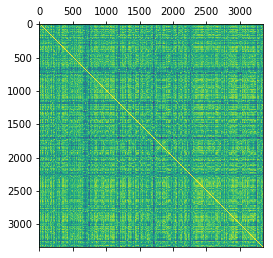

Total true positives = 2973


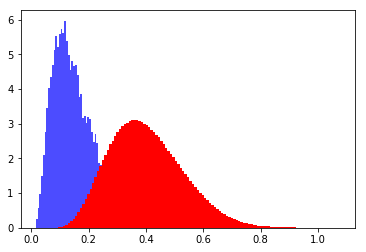

Standard deviation same = 0.09436619662231695
Standard deviation different = 0.1282473730906753
Blah = 28778
Min Same class = 0.015075563262111569
Min Different class = 0.05860760790537345
Minimum = [0.05860761 0.05860761 0.05968907 0.05968907 0.05981968 0.05981968
 0.06290969 0.06290969 0.06320052 0.06320052 0.06327093 0.06327093
 0.06383823 0.06383823 0.06405566 0.06405566 0.06583506 0.06583506
 0.06585157 0.06585157 0.06638415 0.06638415 0.06672695 0.06672695
 0.06679114 0.06679114 0.06798247 0.06798247 0.06844654 0.06844654
 0.0691547  0.0691547  0.06946948 0.06946948 0.06952555 0.06952555
 0.06955765 0.06955765 0.06975842 0.06975842 0.0700902  0.0700902
 0.07095524 0.07095524 0.07101967 0.07101967 0.07136972 0.07136972
 0.07192112 0.07192112 0.072277   0.072277   0.07267941 0.07267941
 0.07296718 0.07296718 0.07302045 0.07302045 0.07341881 0.07341881]
Max = [1.0162473  1.0162473  1.01728023 1.01728023 1.01775407 1.01775407
 1.01852865 1.01852865 1.01879014 1.01879014 1.01879549 1.

In [1]:
import helperFunc
import glob
import os
import re
import random
import math
import numpy as np
from PIL import ImageEnhance,ImageOps
import matplotlib.pyplot as plt
import cv2
from multiprocessing import Pool



from keras.optimizers import SGD,Adam
from keras.layers.core import Lambda
import keras.backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint,Callback
from keras.activations import relu
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers import Input, GlobalAveragePooling2D ,Dense, Concatenate,Conv2DTranspose,Conv2D,Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications import densenet


# Putting this in for some errors that occur on my setup
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

K.set_image_dim_ordering('tf')

# np.random.seed(1337) # for reproducibility

#Number of classes
classes = 293

#Length of feature vector
FEATURES = 1024

#Image dimensions, square images only, can change to non-square
imgDimension = 256

#Dataset location
datasetLoc = 'training_dataset_folder/*'

#Batch_size for training, can fit 12 in a GTX 1070 with ResNet 50
BATCH_SIZE = 12

#Num of images per class, for batch hard training
im_per_class = 4 


#Sorting for file reads
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background, taken from stackoverflow (https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point)
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result



'''
    Augment function, needs an image and an augment type integer.
'''
def augment(im,augType):
        if(augType == 0):
            kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
            im = cv2.filter2D(im, -1, kernel)
        if(augType == 1):
            im = rotate_image(im,30)
            im =cv2.resize(im,(imgDimension,imgDimension))
        if(augType == 2):
            im = rotate_image(im,120)
            im =cv2.resize(im,(imgDimension,imgDimension))
        if(augType == 3):
            im = rotate_image(im,320)
            im =cv2.resize(im,(imgDimension,imgDimension))
        if(augType == 4):
            im = rotate_image(im,230)
            im =cv2.resize(im,(imgDimension,imgDimension))
        if(augType == 5):
            im = np.flip(im,0)
        if(augType == 6):
            im = np.flip(im,1)
        if(augType == 7):
            im[0:70] = 0
        if(augType == 8):
            cl1 = clahe.apply(im[:,:,0])
            cl1[cl1<10] = 0
            im[:,:,0] = cl1
            im[:,:,1] = cl1
            im[:,:,2] = cl1
        if (augType == 9):
            im = cv2.blur(im, (3,3))
        return im


"""
    Keras generator for loading images in a batch hard fashion. Multithreaded by default in keras.
    Modeled for a Tensorflow backend. Takes a static string to the dataset location.
"""

folderList = sorted(glob.glob(datasetLoc),key=numericalSort)

def customGenerator():
    CLASSES = classes
    K = im_per_class
    batchSize = BATCH_SIZE
    #Static paths for now

    yConcat = np.zeros(shape = (batchSize,1+FEATURES),dtype = np.int32)
    
    while True:
        y2 = np.zeros(shape = (1+FEATURES),dtype = np.int32)
        xI = np.zeros(shape = (batchSize,3,imgDimension,imgDimension))
        numFm = random.sample(range(CLASSES), batchSize//K)
        for x in range(batchSize//K):
            imList = glob.glob(folderList[numFm[x]] + "/*")
            numIm = random.sample(range(len(imList)), K)
            #Augmentation, comment out if not needed
            augType = random.sample(range(9), 1)
            for i in range(len(numIm)):
                im = cv2.imread(imList[numIm[i]])
                im = cv2.resize(im,(imgDimension,imgDimension))
                im= augment(im,augType)
                im= np.einsum('lij->jli', im)
                xI[i + (x*K)] = im
                yConcat [i + (x*K)] = y2
                yConcat [i + (x*K)][-1] = numFm[x]

        xI = np.einsum('abcd->acdb',xI)
        yield (xI,yConcat)
        
'''
asoftmax loss for keras, takes in the true and predicted logits. 
Feature vector is passed to this loss function, logits calculated outside.
Works on concatenated logit/feature vector list, taken from https://github.com/pppoe/tensorflow-sphereface-asoftmax on github
'''
def Loss_ASoftmax(true, pred):
    '''
    x: B x D - data
    y: B x 1 - label
    l: 1 - lambda 
    '''
    m = 4
    num_cls = CLASSES
    x = pred[:,CLASSES:]
    yX = true[:,-1]
    y = tf.cast(yX, tf.int32)
    l = 1.0
    eps = 1e-8

    logits = pred[:,:CLASSES]
    if m == 0:

        return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))

    ordinal = tf.constant(list(range(0, BATCH_SIZE)))
    ordinal_y = tf.stack([ordinal, y], axis = 1)

    x_norm = tf.norm(x, axis = 1) + eps
    print(x_norm)
    sel_logits = tf.gather_nd(logits, ordinal_y)

    cos_th = tf.div(sel_logits, x_norm)
    if m == 1:

        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))

    else:

        if m == 2:

            cos_sign = tf.sign(cos_th)
            res = 2*tf.multiply(tf.sign(cos_th), tf.square(cos_th)) - 1

        elif m == 4:

            cos_th2 = tf.square(cos_th)
            cos_th4 = tf.pow(cos_th, 4)
            sign0 = tf.sign(cos_th)
            sign3 = tf.multiply(tf.sign(2*cos_th2 - 1), sign0)
            sign4 = 2*sign0 + sign3 - 3
            res = sign3*(8*cos_th4 - 8*cos_th2 + 1) + sign4
        else:
            raise ValueError('unsupported value of m')

        scaled_logits = tf.multiply(res, x_norm)

        f = 1.0/(1.0+l)
        ff = 1.0 - f
        blah = tf.subtract(scaled_logits, sel_logits)
        print (blah)
        print (ordinal_y)
        b = tf.constant([BATCH_SIZE,CLASSES])

        blah1 = tf.scatter_nd(ordinal_y,blah , b)
        comb_logits_diff = tf.add(logits, blah1) 
        updated_logits = ff*logits + f*comb_logits_diff
        updated_logits = updated_logits*32
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=updated_logits))

    return loss


"""
    Batch hard loss implementation from https://omoindrot.github.io/triplet-loss
    Modified to use a soft margin.
"""
def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask
def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask

def batch_hard_triplet_loss(true, pred, squared=False):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    
    embeddings = pred[:,:-1]
    labels = true[:,-1]
    margin = 0.8
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
#     hP = K.max(hardest_positive_dist)
#     hN =  K.min(hardest_negative_dist)
    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    #Usual batch hard triplet loss:
#     triplet_loss = tf.maximum(hP - hN + margin, 0.0)

    #Soft-margin triplet loss
    triplet_loss = K.log(1.0 + K.exp(hardest_positive_dist - hardest_negative_dist))
    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss
def batch_all_triplet_loss(true, pred, squared=False):
    """Build the triplet loss over a batch of embeddings.

    We generate all the valid triplets and average the loss over the positive ones.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
#     print (labels)
    embeddings = pred[:,:-1]
    labels = true[:,-1]
    
#     print (embeddings)
    margin = 0.7
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss

def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
#     distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)
    distances =  (dot_product/tf.expand_dims(square_norm, 0)*tf.expand_dims(square_norm, 1))
    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = 1-distances
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-8

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances

def l2Norm(x):
    return  K.l2_normalize(x, axis=1)



"""Model generation"""
inp = Input(shape = (3,imgDimension,imgDimension))
base_model = densenet.DenseNet169(weights='imagenet', include_top=False,input_shape=(imgDimension,imgDimension,3))


print ("Loaded initial model")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
fc2 = Dense(FEATURES,activation = 'relu',name = 'embedding_weights',use_bias = False)(x)
fc2 = BatchNormalization()(fc2)
out = Lambda(lambda x: K.l2_normalize(x, axis=1))(fc2)
label = Dense(1,activation='linear',name = 'label')(out)
conc = concatenate([fc2,label], name='xF')
triplet_model = Model(inputs=base_model.input, outputs=conc)

"""Model generation"""

cwd = os.getcwd()
filepath=cwd + "/batchHard_ResNet50-{epoch:02d}-{loss:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

checkpoint = ModelCheckpoint(filepath, monitor='val_predictions_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]
# print (triplet_model.summary())

# triplet_model.load_weights("/home/sohaib/Downloads/Features/batchHard_ResNet50-08-0.58.hdf5",by_name = True)
"""
    Training happens here, same training and validation generators due to laziness
"""
gen_tr = customGenerator()
gen_te = customGenerator()
triplet_model.compile(loss=batch_hard_triplet_loss, optimizer=SGD(0.0009))
triplet_model.fit_generator(gen_tr,validation_data=gen_te,  
                          epochs=7, 
                          verbose=1,
                          workers=4,
                          steps_per_epoch=300, 
                          validation_steps=50,use_multiprocessing = True,callbacks = callbacks_list)


"""
    Folder to infer stuff on
"""
ROOT_DIR = os.getcwd()
imList = sorted(glob.glob(ROOT_DIR+ "/Folder_to_infer_on/*"),key=numericalSort)
print (imList[0])
print (len(imList))


p = 8#multiprocessing cpu_count
pool = Pool(processes=8)
print ("Processors Available = " + str(p))


lst = helperFunc.prepareFeatures(triplet_model,imList,imgDimension,FEATURES)
lst = np.asarray(lst)



activations = lst


# """ 
#     Hardcoded stuff for multi core :p
# """
lst = pool.map(helperFunc.featureSelect,((activations,imList,1),(activations,imList,2),
                              (activations,imList,3),(activations,imList,4),(activations,imList,5),
                              (activations,imList,6),(activations,imList,7),(activations,imList,8)))

tP = 0
masterBlue = []
masterRed = []
masterVar = np.zeros(shape = (FEATURES*3))
for x in range(len(lst)):
    for y in range(len(lst[x][0])):
        masterBlue.append(lst[x][0][y])
    for z in range(len(lst[x][1])):
        masterRed.append(lst[x][1][z])
for x in range(len(lst)):
        tP+= lst[x][2]
print ("Total true positives = " + str(tP))
masterRed = np.sort(masterRed)
plt.hist(masterBlue, normed=True, bins=120, histtype='stepfilled', color='b',alpha=0.7, label='Same')
plt.hist(masterRed, normed=True, bins=120, histtype='stepfilled', color='r', label='Different')
plt.show()

print ("Standard deviation same = " + str(np.std(masterBlue)))
print ("Standard deviation different = " + str(np.std(masterRed)))
print ("Blah = " + str(len(masterBlue)))
print ("Min Same class = " + str(min(masterBlue)))
print ("Min Different class = " + str(min(masterRed)))
print ("Minimum = " + str(masterRed[:60]))
print ("Max = " + str(masterRed[-60:]))

print ("Average Same class = " + str(sum(masterBlue) / float(len(masterBlue))))
print ("Average Different class = " + str(sum(masterRed) / float(len(masterRed))))


# u = np.mean(masterRed)
# entropy = (u*(1-u))/np.var(masterRed)
# print ("Entropy = " + str(entropy))

blueFile = open('blue.txt', 'w')
for item in masterBlue:
    blueFile.write("%s\n" % item)

redFile = open('red.txt', 'w')
for item in masterRed:
    redFile.write("%s\n" % item)

